## The Steady State Heat solver

-----------

2D, Steady Heat Equation with no variation in the x direction

\\[
0 = k \frac{\partial^2 T}{\partial y^2}+H
\\]

\\[
\frac{\partial T}{\partial x} = 0
\\]

with $0 \leqslant x \leqslant 1 $ and $ y_{0}\leqslant y \leqslant y_{1}$


Two models are presented below, each with an analytic solution that the numerical results are tested against.

The general solution is:

$ T = -\frac{h}{2 k}y^{2} + c_{0}y + c_{1} $

where $c_{0}, c_{1}$ are arbitrary constants found by applying each model's boundary conditions

In [1]:
import underworld as uw
import glucifer
import numpy as np
uw.matplotlib_inline()
import matplotlib.pyplot as pyplot
import matplotlib.pylab as pylab
pyplot.ion() # needed to ensure pure python jobs do now hang on show()

rank = uw.rank()

# for machines without matplotlib #
make_graphs = True
try:
    import matplotlib
except ImportError:
    make_graphs=False

# depth range
y0 = -.60
y1 = 1.3

# build mesh and fields
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1"), 
                                 elementRes  = (10, 20), 
                                 minCoord    = (0., y0), 
                                 maxCoord    = (1., y1))

tField    = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=1, dataType='double')
topWall = mesh.specialSets['MaxJ_VertexSet']
bottomWall = mesh.specialSets['MinJ_VertexSet']

/Users/jmansour/virtualenvs/general/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# # analytic solution definitions
def analyticTemperature(y, h, k, c0, c1):
     return -h/(2*k)*y*y + c0*y + c1

def exactDeriv(y, h, k, c0):
    return -h/k*y + c0

## Model 1)


2D, Heat Equation with a Dirichlet BC (top) and a Neumann BC (bottom).

$T(x,y_{1}) = T_{1}$

$ -k\nabla{T} \mid _{y_{0}} = \left[\,0.0,\,f\,\right] $


------

Effectively a 1D problem in $y$-axis - arbitrary constants are:

$c_{0} = -f + \frac{h}{k}y_{0}$

$c_{1} = T_{1} + \frac{h}{2 k}y_{1}^2 - c_{0}y_{1} $

------

We implement the above boundary conditions using: 
 * a `DirichletCondition` for $T(y_{1})=T_{1}$
 * a `NeumannCondition` object for $ -k\nabla{T}\mid_{y_{0}} = \left[\,0.0,\,f\,\right] $

The `NeumannCondition` object, used with the `SteadyStateHeat` object, defines a $T$ flux along a boundary such that:
  * $ k\nabla T \cdot n = h $ on $ \Gamma_{h} $
  
    where:  
      $\Gamma_{h}$ is the set of vertices along the surface of the domain,  
      $ n $ is the unit normal facing outwards from the surface (at $n\mid_{y_{0}}=\left[0,-1\right]$)  
      $ k \nabla T $ is the flux vector prescribed on the surface.

An example implementation  

```nbc = uw.conditions.NeumannCondition( flux=[0.0,f], variable=tField,
                                      nodeIndexSet=mesh.specialSets["MinJ_VertexSet"] )```

Applies a flux vector [0.0, f] to the `tField` over the boundary vertices in the set `nodeIndexSet`. The outward facing normal along `nodeIndexSet` is used to calculate the $h$.

In [3]:
T1 = 8.0       # surface temperature
k = 0.70        # diffusivity
h = 9.0     # heat production, source term
f = -5.23 

# analytic solution definitions
# 1 dirichlet conditions (top) + 1 neumann (bottom)
c0 = 1.0/k*(h*y0-f)
c1 = T1 + h/(2.0*k)*y1**2 - c0*y1

In [4]:
for ii in topWall:
    tField.data[ii] = T1

# define neumann condition
nbc = uw.conditions.NeumannCondition( flux=[0.0,f], 
                                      variable=tField, 
                                      nodeIndexSet=(bottomWall) )

# flag the dirichlet conditions on the topWall only
bc = uw.conditions.DirichletCondition(tField, indexSetsPerDof=(topWall) )

# define heat eq. system
ss = uw.systems.SteadyStateHeat( temperatureField  = tField,
                                 fn_diffusivity = k,
                                 fn_heating     = h,
                                 conditions     = [bc, nbc] ) 

In [5]:
solver = uw.systems.Solver(ss)
solver.solve()

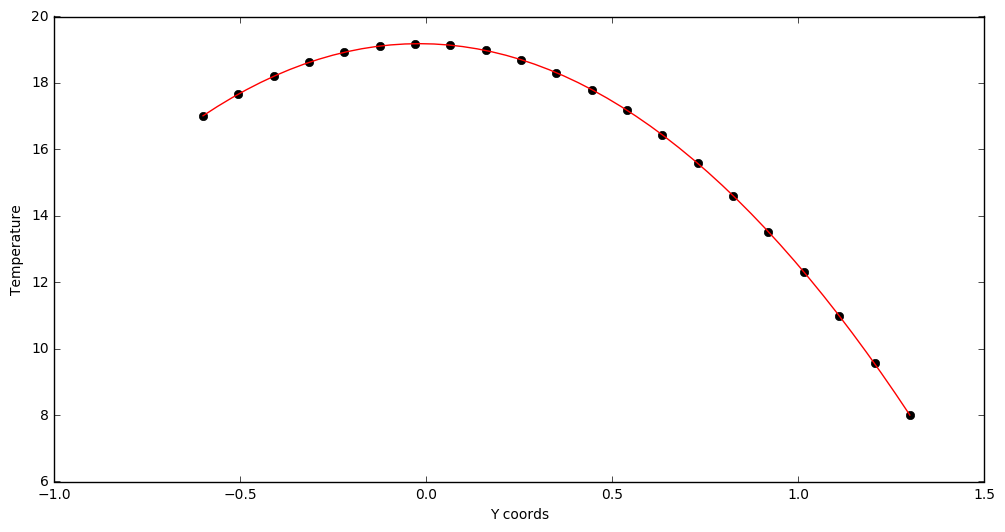

Numerical flux at y =  -0.6 is 6.86069927417
Exact     flux at y =  -0.6 is 7.47142857143
|T - T_analytic|_2 = 1.997e-04

|T|_2 = 7.569e+01

Rel. error = 2.638e-06


In [6]:
# create numpy arrays for analytics
yvals       = np.zeros(len(mesh.specialSets['MinI_VertexSet'].data))
ycoord      = np.zeros_like(yvals)
analytic    = np.zeros_like(yvals)

ids = mesh.specialSets['MinI_VertexSet']
yvals[:] = tField.evaluate(ids).T

ycoord = tField.mesh.data[ids.data,[1]]
analytic = analyticTemperature(ycoord, h, k, c0, c1)

abserr = uw.utils._nps_2norm(analytic - yvals)
mag = uw.utils._nps_2norm(analytic)
relerr = abserr / mag

from mpi4py import MPI
comm = MPI.COMM_WORLD
# assuming order in the allgather is the same
coords = comm.allgather(ycoord)
numerical = comm.allgather(yvals)

if rank == 0:
    # build matplot lib graph of result only on proc 0

    # 1st build exact solution hiRes
    big = np.linspace(y0,y1)
    cool = analyticTemperature(big, h, k, c0, c1)

    pylab.rcParams[ 'figure.figsize'] = 12, 6
    pyplot.plot(coords, numerical, 'o', color = 'black', label='numerical') 
    pyplot.plot(big, cool, color = 'red', label="exact") 
    pyplot.xlabel('Y coords')
    pyplot.ylabel('Temperature')
    pyplot.show()


if rank == 0:
    threshold = 3.0e-4
    yspot = y0
    print "Numerical flux at y = " ,yspot,"is", tField.fn_gradient.evaluate([0.2,yspot])[0][1]
    print "Exact     flux at y = " ,yspot,"is", exactDeriv(yspot,h,k,c0)
    print "|T - T_analytic|_2 = {0:.3e}\n\n|T|_2 = {1:.3e}\n".format(abserr, mag)
    print "Rel. error = {0:.3e}".format(relerr)
    if relerr > threshold:
        raise RuntimeError("The numerical solution is outside the error threshold of the analytic solution." \
                           "The Relative error was ", relerr," the threshold is ", threshold)

## Model 2) 

2D, Steady State Heat Equation with Dirichlet BC at top and bottom boundary.

$T(x,y_{1}) = T_{1}$

$ T(x,y_{0}) = T_{0} $

------

arbitrary constants are:

$ c_{0} = \frac{1}{y_{1}-y_{0}} \left[ T_{1}-T_{0}+\frac{h} {2k}(y_{1}^2-y_{0}^2) \right] $

$c_{1} = T_{1} + \frac{h}{2k}y_{1}^2 - c_{0}y_{1}$


In [7]:
# Model parameters
T1 = 8.0   # top surface temperature
T0 = 4.0   # bottom surface temperature
k = 0.50    # diffusivity
h = 1.0e0  # heat production, source term

# arbitrary constant given the 2 dirichlet conditions
c0 = (T1-T0+h/(2*k)*(y1**2-y0**2)) / (y1-y0)
c1 = T1 + h/(2*k)*y1**2 - c0*y1

In [8]:
# set boundary conditions
for ii in topWall:
    tField.data[ii] = T1
for ii in bottomWall:
    tField.data[ii] = T0

# flag boundary conditions
bc = uw.conditions.DirichletCondition(tField, indexSetsPerDof=(topWall+bottomWall) )

# define heat eq. system
ss = uw.systems.SteadyStateHeat( temperatureField  = tField,
                                 fn_diffusivity = k,
                                 fn_heating     = h,
                                 conditions     = [bc] )

In [9]:
solver = uw.systems.Solver(ss)
solver.solve()

In [10]:
# create numpy arrays for analytics
yvals       = np.zeros(len(mesh.specialSets['MinI_VertexSet'].data))
ycoord      = np.zeros_like(yvals)
analytic    = np.zeros_like(yvals)

ids = mesh.specialSets['MinI_VertexSet']
yvals[:] = tField.evaluate(ids).T

ycoord   = tField.mesh.data[ids.data,[1]]
analytic = analyticTemperature(ycoord, h, k, c0, c1)

abserr = uw.utils._nps_2norm(analytic - yvals)
mag = uw.utils._nps_2norm(analytic)
relerr = abserr / mag

from mpi4py import MPI
comm = MPI.COMM_WORLD
# assuming order in the allgather is the same
coords = comm.allgather(ycoord)
numerical = comm.allgather(yvals)

In [11]:
if rank == 0:
    threshold = 3.0e-4
    yspot = y0
    print "Numerical flux at y = " ,yspot,"is", tField.fn_gradient.evaluate([0.2,yspot])[0][1]
    print "Exact flux at y=" ,yspot,"is", exactDeriv(yspot,h,k,c0)
    print "\n|T - T_analytic|_2 = {0:.3e}\n\n|T|_2 = {1:.3e}\n".format(abserr, mag)
    print "Rel. error = {0:.3e}".format(relerr)
    if relerr > threshold:
        raise RuntimeError("The numerical solution is outside the error threshold of the analytic solution." \
                           "The Relative error was ", relerr," the threshold is ", threshold)  
        

Numerical flux at y =  -0.6 is 3.91023051505
Exact flux at y= -0.6 is 4.00526315789

|T - T_analytic|_2 = 2.233e-04

|T|_2 = 3.065e+01

Rel. error = 7.286e-06


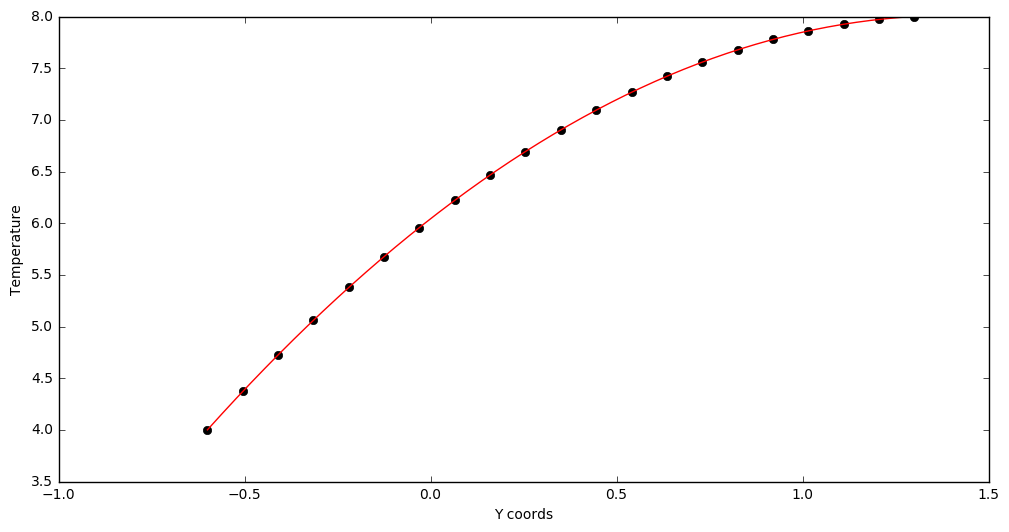

In [12]:

if rank == 0:
    # build matplot lib graph of result only on proc 0

    # 1st build exact solution hiRes
    big = np.linspace(y0,y1)
    cool = analyticTemperature(big, h, k, c0, c1)

    pylab.rcParams[ 'figure.figsize'] = 12, 6
    pyplot.plot(coords, numerical, 'o', color = 'black', label='numerical') 
    pyplot.plot(big, cool, color = 'red', label="exact") 
    pyplot.xlabel('Y coords')
    pyplot.ylabel('Temperature')
    pyplot.show()
